In [498]:
import pandas as pd
# from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib
import matplotlib.pyplot as plt


model_rfr_ftr = joblib.load('savemodel_rfr_ftr.sav')
model_rfr_hpo = joblib.load('savemodel_rfr_ftr_hpo.sav')
model_rfr_hpov = joblib.load('savemodel_rfr_ftr_hpov.sav')

model_etr = joblib.load('savemodel_etr.sav')
model_etr_hpov = joblib.load('savemodel_etr_hpov.sav')

model_dtr_ftr = joblib.load('savemodel_dtr_ftr.sav')
model_dtr_hpov = joblib.load('savemodel_dtr_hpov.sav')


model_mlr_ftr = joblib.load('savemodel_mlr_ftr.sav')

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]

In [499]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [500]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [501]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [502]:
x_pre = imputer.transform(dfpre)

In [503]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [504]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [505]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001


In [506]:
# dfpre["True North Wind Direction"] =  180 +  np.rad2deg(np.arctan((dfpre["eastwind"])/(dfpre["northwind"])))

condwind = [(dfpre['eastwind']>0) & (dfpre['northwind']<0),
            (dfpre['eastwind']<0) & (dfpre['northwind']>0),
            (dfpre['eastwind']>0) & (dfpre['northwind']>0)]

choicewind = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"])))]

dfpre["True North Wind Direction"] = np.select(condwind, choicewind, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))))

# dfpre["True North Wind Direction"] = np.where(dfpre["True North Wind Direction"] > 0, 180 + dfpre["True North Wind Direction"] , 180 - dfpre["True North Wind Direction"])

# if dfpre["True North Wind Direction"]<0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]
# elif dfpre["True North Wind Direction"]>0:
#     dfpre["True North Wind Direction"] = 180 - dfpre["True North Wind Direction"]

In [507]:
# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

# dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))


# 
condcurr = [(dfpre['eastcurrent']<0) & (dfpre['northcurrent']>0),
            (dfpre['eastcurrent']>0) & (dfpre['northcurrent']<0),
            (dfpre['eastcurrent']<0) & (dfpre['northcurrent']<0)]

choicecurr = [360 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              180 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))),
              270 - np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"])))]

dfpre["True North Current Direction"] = np.select(condcurr, choicecurr, 
                                                np.abs(np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))))

In [508]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [509]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,251.408180,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,254.458891,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,259.749663,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,266.724504,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [510]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [511]:
# Exclude data for the month of June to check the model's forecasting performance 

dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

# Extract information of a journey from a single day

koege_dep = df[df['Time'].dt.strftime('%Y-%m-%d %H:%M:%S') == '2021-05-31 23:00:00']
koege_arr = dfdate6[dfdate6['Time'].dt.strftime('%Y-%m-%d') == '2021-06-01']

# Drop the departure time for next trip

koege_arr2 = koege_arr.drop(koege_arr.index[14])

# To gain information for a single trip from Koege to Ronne

ronne_arr = koege_arr.drop(koege_arr.index[4:15])

dfday6 = pd.concat([koege_dep,koege_arr2])
dfone6 = pd.concat([koege_dep,ronne_arr])

# # For Qgis Single Journey
# dfday6.to_csv("AIS_01_06_21_koegeronne.csv")

In [512]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Unnamed: 0                            3506 non-null   int64         
 1   Time                                  3506 non-null   datetime64[ns]
 2   LON                                   3506 non-null   float64       
 3   LAT                                   3506 non-null   float64       
 4   Temperature above oceans              3506 non-null   float64       
 5   Air density above oceans              3405 non-null   float64       
 6   Max wave height                       3152 non-null   float64       
 7   Swell period                          3152 non-null   float64       
 8   Wind wave period                      3152 non-null   float64       
 9   Wave period                           3152 non-null   float64       
 10  

Check STW and SOG

In [513]:
# Keep this part for SOG and STW check

# df["vgms"] = df["SOG"]/1.9438
# rad_gamma = np.deg2rad(df["True North Current Direction"])
# rad_cog = np.deg2rad(df["COG"])
# df["vgx"] = df["vgms"] * np.sin(rad_cog)
# df["vcx"] = df["Current Speed"] * np.sin(rad_gamma)
# df["stw_x"] = (df["vgx"] - df["vcx"])
# df["vgy"] = df["vgms"] * np.cos(rad_cog)
# df["vcy"] = df["Current Speed"] * np.cos(rad_gamma)
# df["stw_y"] = (df["vgy"] - df["vcy"])
# df["vwms_a"] = np.sqrt(df["stw_x"]**2 + df["stw_y"]**2)
# df["stw_act"] = df["vwms_a"]*1.9438

# dfsog= df[df["SOG"] > df["stw_act"] ]
# dfsog.head(n=10)
# dfsog.to_csv("SOG_june_update.csv")

# dfstw= df[df["SOG"] < df["stw_act"] ]
# dfstw.head(n=10)
# dfstw.to_csv("STW_june_update.csv")


Special Section

In [514]:
# # Check model performance for one trip
# # PLEASE COMMMENT WHEN DONE !!!

# dfdate6 = dfone6

Exporting File

In [515]:
# df.to_csv('June_update.csv')

Measure performance in one month

In [516]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,100.989288,164.871808,15.554049,66.843493,57.268527,0.144914,10.248966,21.771601,184.345879
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,108.737155,153.650411,11.071672,60.455881,51.313932,0.246220,11.364678,25.671971,199.414773
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,114.910729,153.031589,16.281358,57.086511,46.894106,0.284315,12.666946,32.436488,199.442652
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,123.568984,153.643227,69.175152,55.507286,56.527939,0.300428,13.386999,50.510505,189.415252
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,26.476633,41.766758,158.632374,159.050718,167.192888,0.262897,12.053293,74.157471,180.552404


In [517]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [518]:
# Rearrange column to match model 
# Also dropping the features as described in the main script

dfdate6 = dfdate6[['oceantemperature','waveperiod','surftemp','windwaveswellheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]


# dfdate6 = dfdate6[['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod','surftemp','windwaveswellheight','swellheight','windwaveheight','draught','sog','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir','truewavedir', 'truenorthwinddir' , 'truenorthcurrentdir']]

In [519]:
stats2 = dfdate6['curspeed'].value_counts()

In [520]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)


In [521]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [522]:
xdate = imputer.transform(dfdate6)

In [523]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [524]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

x_date = dfdate6tr.drop(['sog','truecurrentdir','truewinddir'],axis=1)
y_date = dfdate6tr.sog

In [525]:
def evaluate(model, test_features, test_labels):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

    predictions = model.predict(test_features)
    rsquared = model.score(test_features,test_labels)
    expVar = explained_variance_score(test_labels,predictions)
    MAE = mean_absolute_error(test_labels,predictions)
    MAD = median_absolute_error(test_labels,predictions)
    RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

    print(f"Model Performance of {model}")
    print(f"R^2: {rsquared:0.4f}")
    print(f"explained Variance = {expVar:0.4f}")
    print(f"MAE = {MAE:0.4f}")
    print(f"RMSE = {RMSE:0.4f}")
    print(f"MAD = {MAD:0.4f}\n")
    
    return rsquared,expVar,MAE,RMSE,MAD,predictions

rf_rsquared,rf_expVar,rf_MAE,rf_RMSE,rf_MAD,y_pred_rfr = evaluate(model_rfr_ftr,x_date,y_date)

# plt.figure(figsize=(10,10))
# plt.scatter(y_date, y_pred_rfr_ftr, c='crimson')
# # plt.yscale('log')
# # plt.xscale('log')

# p1 = max(max(y_pred_rfr_ftr), max(y_date))
# p2 = min(min(y_pred_rfr_ftr), min(y_date))
# plt.plot([p1, p2], [p1, p2], 'b-')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
# plt.show()

Model Performance of RandomForestRegressor(random_state=42)
R^2: 0.8634
explained Variance = 0.8822
MAE = 0.8243
RMSE = 1.1329
MAD = 0.6354



In [526]:
rfo_rsquared,rfo_expVar,rfo_MAE,rfo_RMSE,rfo_MAD,y_pred_rfr_hpov = evaluate(model_rfr_hpov,x_date,y_date)

Model Performance of RandomForestRegressor(bootstrap=False, max_depth=136, max_features=9,
                      min_samples_split=5, n_estimators=267, random_state=42)
R^2: 0.8563
explained Variance = 0.8775
MAE = 0.8719
RMSE = 1.1618
MAD = 0.6817



In [527]:
# Prediction using ETR

etr_rsquared,etr_expVar,etr_MAE,etr_RMSE,etr_MAD,y_pred_etr_hpov = evaluate(model_etr_hpov,x_date,y_date)

Model Performance of ExtraTreesRegressor(max_depth=120, min_samples_split=4, n_estimators=300,
                    random_state=42)
R^2: 0.8740
explained Variance = 0.8921
MAE = 0.8079
RMSE = 1.0879
MAD = 0.6494



In [528]:
# Comparing performance with DTR model (not optimzed)

dtr_rsquared,dtr_expVar,dtr_MAE,dtr_RMSE,dtr_MAD,y_pred_dtr = evaluate(model_dtr_ftr,x_date,y_date)


# plt.figure(figsize=(10,10))
# plt.scatter(y_date, y_pred_dtr_ftr, c='crimson')
# # plt.yscale('log')
# # plt.xscale('log')

# p1 = max(max(y_pred_dtr_ftr), max(y_date))
# p2 = min(min(y_pred_dtr_ftr), min(y_date))
# plt.plot([p1, p2], [p1, p2], 'b-')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
# plt.show()

Model Performance of DecisionTreeRegressor()
R^2: 0.7870
explained Variance = 0.8011
MAE = 1.0191
RMSE = 1.4148
MAD = 0.7004



In [529]:
# Prediction using DTR optimized

dtro_rsquared,dtro_expVar,dtro_MAE,dtro_RMSE,dtro_MAD,y_pred_dtr_opt = evaluate(model_dtr_hpov,x_date,y_date)


Model Performance of DecisionTreeRegressor(max_depth=80, max_features=12, min_samples_leaf=10,
                      min_samples_split=3)
R^2: 0.8388
explained Variance = 0.8592
MAE = 0.9196
RMSE = 1.2307
MAD = 0.6741



In [530]:
# Comparing performance with MLR as baseline (not optimzed)
mlr_rsquared,mlr_expVar,mlr_MAE,mlr_RMSE,mlr_MAD,y_pred_mlr =evaluate(model_mlr_ftr,x_date,y_date)

# plt.figure(figsize=(10,10))
# plt.scatter(y_date, y_pred_mlr_ftr, c='crimson')
# # plt.yscale('log')
# # plt.xscale('log')

# p1 = max(max(y_pred_mlr_ftr), max(y_date))
# p2 = min(min(y_pred_mlr_ftr), min(y_date))
# plt.plot([p1, p2], [p1, p2], 'b-')
# plt.xlabel('True Values', fontsize=15)
# plt.ylabel('Predictions', fontsize=15)
# plt.axis('equal')
# plt.show()

Model Performance of LinearRegression()
R^2: 0.5757
explained Variance = 0.5961
MAE = 1.4247
RMSE = 1.9966
MAD = 1.2724



Evaluation using Cross Validation

In [531]:
from sklearn.model_selection import cross_val_score

score_rf = cross_val_score(model_rfr_ftr,x_date,y_date,
                           scoring='r2',cv=10)
score_et = cross_val_score(model_etr,x_date,y_date,
                           scoring='r2',cv=10)
score_dt = cross_val_score(model_dtr_ftr,x_date,y_date,
                           scoring='r2',cv=10)
score_mlr = cross_val_score(model_mlr_ftr,x_date,y_date,
                           scoring='r2',cv=10)

<Figure size 500x300 with 0 Axes>

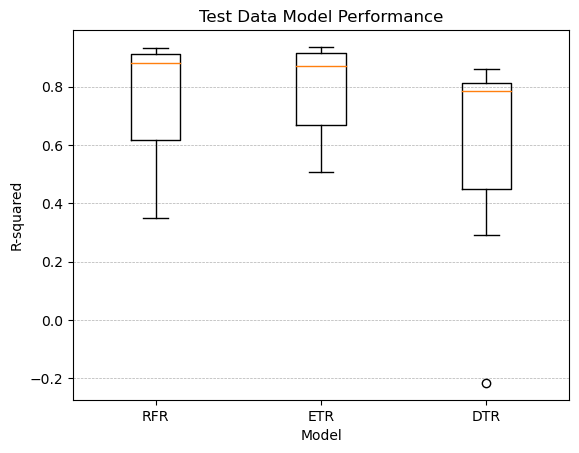

In [532]:
scores_test = [score_rf,score_et,score_dt]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
# ax = fig.add_axes([0, 0, 1, 1])
fig,ax = plt.subplots()
plt.title("Test Data Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
plt.boxplot(scores_test)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'ETR',
                    'DTR'])
plt.show()

In [533]:
score_rfopt = cross_val_score(model_rfr_hpov,x_date,y_date,
                           scoring='r2',cv=10)
score_etopt = cross_val_score(model_etr_hpov,x_date,y_date,
                           scoring='r2',cv=10)
score_dtopt = cross_val_score(model_dtr_hpov,x_date,y_date,
                           scoring='r2',cv=10)

<Figure size 500x300 with 0 Axes>

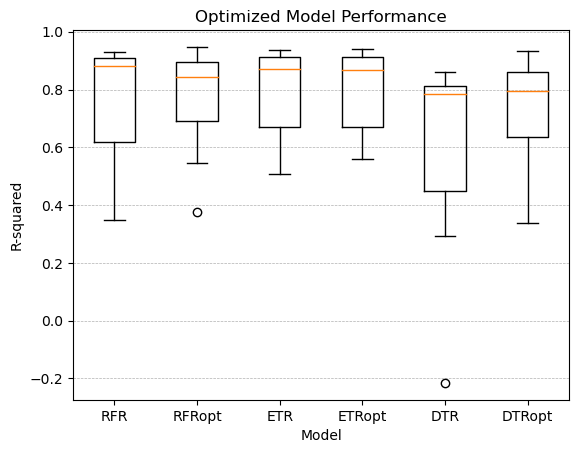

In [534]:
scores_opt = [score_rf,score_rfopt,score_et,score_etopt,score_dt,score_dtopt]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("R-squared")
plt.xlabel("Model")
plt.yscale('linear')
ax.boxplot(scores_opt)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'RFRopt',
                    'ETR', 'ETRopt',
                    'DTR','DTRopt'])
plt.show()

RMSE evaluations

In [561]:
rmse_rf = cross_val_score(model_rfr_ftr,x_date,y_date,
                           scoring='neg_root_mean_squared_error',cv=10)
rmse_et = cross_val_score(model_etr,x_date,y_date,
                           scoring='neg_root_mean_squared_error',cv=10)
rmse_dt = cross_val_score(model_dtr_ftr,x_date,y_date,
                           scoring='neg_root_mean_squared_error',cv=10)
rmse_rfopt = cross_val_score(model_rfr_hpov,x_date,y_date,
                           scoring='neg_root_mean_squared_error',cv=10)
rmse_etopt = cross_val_score(model_etr_hpov,x_date,y_date,
                           scoring='neg_root_mean_squared_error',cv=10)
rmse_dtopt = cross_val_score(model_dtr_hpov,x_date,y_date,
                           scoring='neg_root_mean_squared_error',cv=10)

<Figure size 500x300 with 0 Axes>

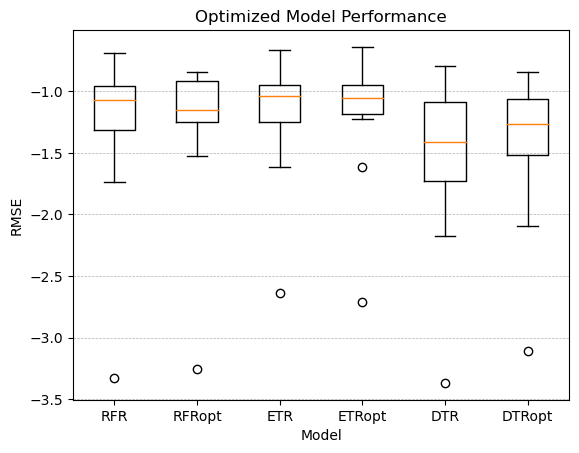

In [562]:
rmse_opt = [rmse_rf,rmse_rfopt,rmse_et,rmse_etopt,rmse_dt,rmse_dtopt]
fig = plt.figure(figsize=(5,3))
# Creating axes instance
fig,ax = plt.subplots() 
plt.title("Optimized Model Performance")
plt.ylabel("RMSE")
plt.xlabel("Model")
plt.yscale('linear')
ax.boxplot(rmse_opt)
plt.grid(axis='y',linestyle = '--', linewidth = 0.5)
ax.set_xticklabels(['RFR', 'RFRopt',
                    'ETR', 'ETRopt',
                    'DTR','DTRopt'])
plt.show()

STW Calculation

In [535]:
ydate_pred = y_pred_rfr_hpov
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["nwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred       gamma    nwinddir
119   18.998906  18.545975  184.345879   21.771601
120   19.334278  18.752648  199.414773   25.671971
121   18.911047  18.741293  199.442652   32.436488
122   13.854933  14.138282  189.415252   50.510505
126    9.305198  10.458268  180.552404   74.157471
...         ...        ...         ...         ...
7413  19.072622  18.482726  104.966166  110.959927
7414  17.696584  17.242701   86.330174  126.837339
7415  15.963630  16.555436   83.486098  119.018621
7418   8.988086   8.448150   89.745593  140.723377
7419  17.672769  17.217846   15.792214  143.902554

[322 rows x 4 columns]


In [536]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,truenorthwinddir,truenorthcurrentdir,sog_act,sog_pred,gamma,nwinddir
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,57.268527,21.771601,184.345879,18.998906,18.545975,184.345879,21.771601
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,51.313932,25.671971,199.414773,19.334278,18.752648,199.414773,25.671971
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,46.894106,32.436488,199.442652,18.911047,18.741293,199.442652,32.436488
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,56.527939,50.510505,189.415252,13.854933,14.138282,189.415252,50.510505
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,167.192888,74.157471,180.552404,9.305198,10.458268,180.552404,74.157471
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,119.939682,72.289134,184.264563,20.935741,17.554855,184.264563,72.289134
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,176.253205,60.000273,182.129556,12.419853,11.221833,182.129556,60.000273
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,54.778275,68.405148,275.295245,20.447721,16.282219,275.295245,68.405148
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,41.385363,84.710374,187.199243,18.702889,17.639758,187.199243,84.710374
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,159.775304,89.075598,281.621166,16.155258,15.432294,281.621166,89.075598


In [537]:
# Conversion of predicted SOG to m/s

dfprog["vgms"] = dfprog["sog_pred"]/1.9438

# Conversion of actual SOG to m/s

dfprog["vgms_act"] = dfprog["sog_act"]/1.9438

In [538]:
# Conversion of the angles to radian

rad_gamma = np.deg2rad(dfprog["gamma"])
rad_cog = np.deg2rad(dfprog["cog"])

In [539]:
# Calculation of the predicted x-component of SOG

dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

# Calculation of the actual x-component of SOG

dfprog["vgx_act"] = dfprog["vgms_act"] * np.sin(rad_cog)
dfprog["stw_x_act"] = (dfprog["vgx_act"] - dfprog["vcx"])


In [540]:
# Calculation of the predicted y-component of SOG 

dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

# Calculation of the actual y-component of SOG

dfprog["vgy_act"] = dfprog["vgms_act"] * np.cos(rad_cog)
dfprog["stw_y_act"] = (dfprog["vgy_act"] - dfprog["vcy"])


In [541]:
# For the actual data
dfprog["vwms_a"] = np.sqrt(dfprog["stw_x_act"]**2 + dfprog["stw_y_act"]**2)
dfprog["stw_act"] = dfprog["vwms_a"]*1.9438

# For the prediction

dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438



In [542]:
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vgms_act','vgx_act','stw_x_act',
                      'vgy_act','stw_y_act',
                      'vwms_p','vwms_a'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,truenorthwinddir,truenorthcurrentdir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,57.268527,21.771601,184.345879,18.998906,18.545975,184.345879,21.771601,18.959384,18.506503
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,51.313932,25.671971,199.414773,19.334278,18.752648,199.414773,25.671971,19.429024,18.847569
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,46.894106,32.436488,199.442652,18.911047,18.741293,199.442652,32.436488,19.013330,18.843647
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,56.527939,50.510505,189.415252,13.854933,14.138282,189.415252,50.510505,13.977521,14.260636
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,167.192888,74.157471,180.552404,9.305198,10.458268,180.552404,74.157471,8.906447,10.058889
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,119.939682,72.289134,184.264563,20.935741,17.554855,184.264563,72.289134,21.102027,17.721583
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,176.253205,60.000273,182.129556,12.419853,11.221833,182.129556,60.000273,11.961506,10.763886
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,54.778275,68.405148,275.295245,20.447721,16.282219,275.295245,68.405148,20.747280,16.582024
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,41.385363,84.710374,187.199243,18.702889,17.639758,187.199243,84.710374,18.652546,17.589520
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,159.775304,89.075598,281.621166,16.155258,15.432294,281.621166,89.075598,15.886581,15.163619


In [543]:
dfprog.describe()

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,truenorthwinddir,truenorthcurrentdir,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,287.133146,3.400343,287.256948,0.661506,5.282713,197.436423,189.432992,5.832751,0.092478,96.072486,193.881748,155.282564,17.449699,17.003458,155.282564,193.881748,17.462763,17.016541
std,6.306975,0.965020,4.797442,0.541832,0.162420,86.327689,88.499255,3.020207,0.068917,62.354792,89.816472,102.716811,3.069944,2.778095,102.716811,89.816472,3.087330,2.803566
min,269.606903,1.915993,275.485352,0.073242,4.754639,82.664990,79.551648,0.441768,0.002006,0.200645,3.207821,0.112383,5.224523,5.440377,0.112383,3.207821,5.238308,5.450546
25%,285.292786,2.692099,286.832031,0.272528,5.199718,103.569971,101.685445,3.442231,0.043318,30.508970,120.064906,83.669063,16.568861,16.666555,83.669063,120.064906,16.602154,16.704285
50%,289.505615,3.160003,289.004578,0.474936,5.290842,193.360899,125.125521,5.528616,0.073482,102.070984,193.709354,129.304190,18.413643,17.982592,129.304190,193.709354,18.410164,18.040316
75%,291.391602,3.764453,290.458008,0.788779,5.381292,283.259801,279.238872,7.569939,0.123647,158.513351,279.768652,249.619550,19.421633,18.574990,249.619550,279.768652,19.454912,18.622257
max,294.685303,6.291378,292.665649,2.565230,5.657671,319.851509,304.969531,13.386999,0.417155,179.699225,357.291804,359.450078,21.031230,19.859596,359.450078,357.291804,21.102027,19.978857


In [544]:
# FOC in T/d
dfprog["foc_act_d"] = ((dfprog["stw_act"]/17.7)**3) * 21.14112
dfprog["foc_pred_d"] = ((dfprog["stw_pred"]/17.7)**3) * 21.14112

# FOC in T/h
dfprog["foc_act_h"] = ((dfprog["stw_act"]/17.7)**3) * 0.8808
dfprog["foc_pred_h"] = ((dfprog["stw_pred"]/17.7)**3) * 0.8808

In [545]:
dfprog.head(n=10)

,oceantemperature,waveperiod,surftemp,windwaveswellheight,draught,cog,heading,windspeed,curspeed,truewavedir,...,sog_act,sog_pred,gamma,nwinddir,stw_act,stw_pred,foc_act_d,foc_pred_d,foc_act_h,foc_pred_h
119,275.823975,5.291555,278.661621,1.759765,5.281861,102.832130,100.782313,10.248966,0.144914,57.268527,...,18.998906,18.545975,184.345879,21.771601,18.959384,18.506503,25.982496,24.164693,1.082506,1.006771
120,275.924011,5.697814,278.936035,1.950242,5.289403,98.691177,96.934816,11.364678,0.246220,51.313932,...,19.334278,18.752648,199.414773,25.671971,19.429024,18.847569,27.961543,25.525498,1.164958,1.063466
121,276.285034,6.126474,279.209961,2.189788,5.288446,99.598616,97.525758,12.666946,0.284315,46.894106,...,18.911047,18.741293,199.442652,32.436488,19.013330,18.843647,26.204915,25.509567,1.091772,1.062802
122,277.189484,6.284671,279.216553,2.565230,5.290781,88.475574,106.941521,13.386999,0.300428,56.527939,...,13.854933,14.138282,189.415252,50.510505,13.977521,14.260636,10.411148,11.056684,0.433758,0.460653
126,277.408752,6.291378,279.319824,2.414834,4.842367,142.835632,227.680837,12.053293,0.262897,167.192888,...,9.305198,10.458268,180.552404,74.157471,8.906447,10.058889,2.693529,3.880237,0.112220,0.161662
127,277.399658,6.061778,279.230591,2.021695,4.841530,301.967467,301.939331,11.667020,0.181460,119.939682,...,20.935741,17.554855,184.264563,72.289134,21.102027,17.721583,35.824550,21.218550,1.492554,0.884026
128,275.499359,5.927387,287.026093,1.754722,4.852890,214.510860,251.124778,9.043038,0.281402,176.253205,...,12.419853,11.221833,182.129556,60.000273,11.961506,10.763886,6.524779,4.754615,0.271841,0.198091
130,276.370789,5.959699,285.581279,1.585114,4.923635,129.288093,126.654641,8.393962,0.185268,54.778275,...,20.447721,16.282219,275.295245,68.405148,20.747280,16.582024,34.048008,17.382842,1.418538,0.724219
131,277.268555,5.876345,279.216553,1.731217,4.925344,108.812979,107.899157,9.328641,0.133047,41.385363,...,18.702889,17.639758,187.199243,84.710374,18.652546,17.589520,24.741303,20.747709,1.030794,0.864409
134,277.220703,5.585643,279.216553,1.490863,5.202804,288.331616,270.659656,9.022607,0.139192,159.775304,...,16.155258,15.432294,281.621166,89.075598,15.886581,15.163619,15.286199,13.292809,0.636867,0.553817


In [546]:
# df_foc=dfprog.drop(['oceantemperature','waveheight','swellperiod','windwaveperiod','waveperiod',
#                     'surftemp','windwaveswellheight','swellheight','windwaveheight','swellheight',
#                     'windwaveheight','draught','cog','heading','windspeed','curspeed','truewinddir','truecurrentdir','trueswelldir','truewindwavedir',
#                     'truewavedir','gamma','nwinddir'],axis=1)

df_foc=dfprog.drop(['oceantemperature','waveperiod',
                    'surftemp','windwaveswellheight',
                    'draught','cog','heading','windspeed','curspeed',
                    'truewavedir'],axis=1)

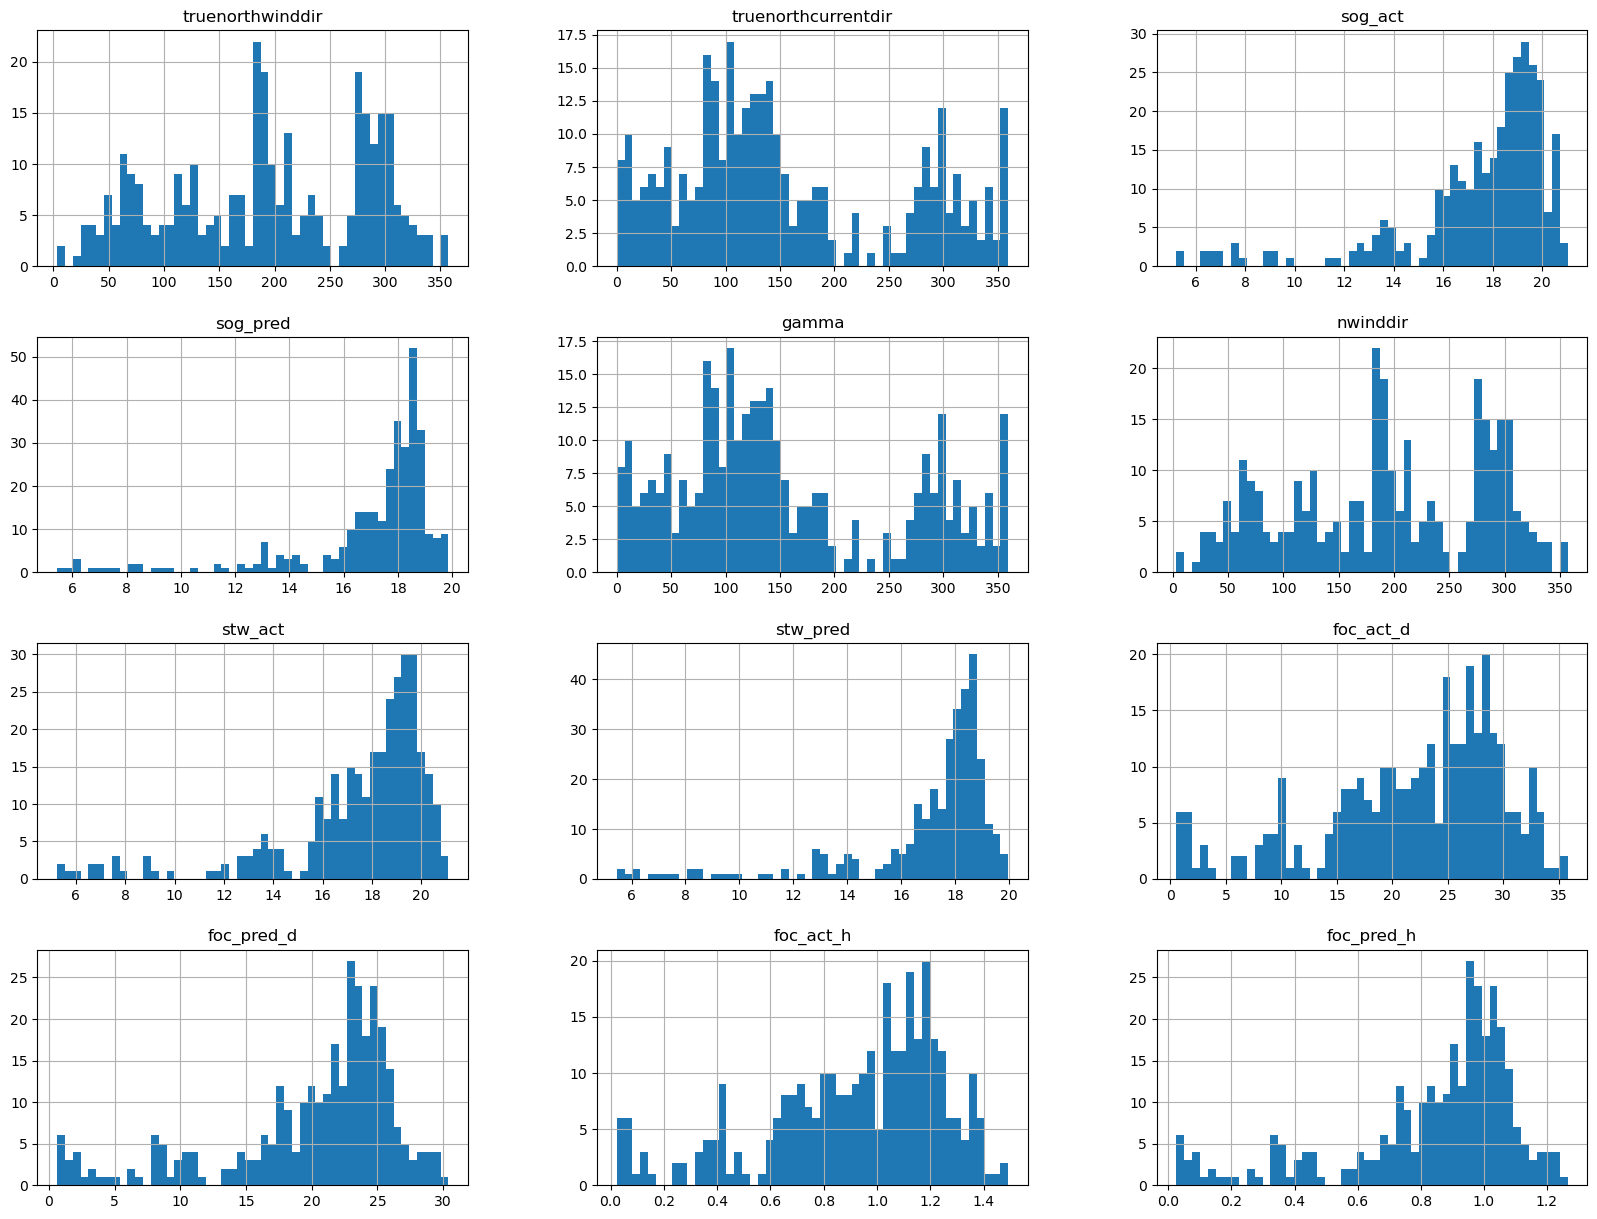

In [547]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_foc.hist(bins=50,figsize=(20,15))
plt.show()

In [548]:
foc_month = dfprog['foc_pred_d'].mean()
foc_month_a = dfprog['foc_act_d'].mean()
print(f"Mean of predicted FOC in a month is {foc_month} T/d")
print(f"Mean of actual FOC in a month is {foc_month_a} T/d")

Mean of predicted FOC in a month is 20.118108095327766 T/d
Mean of actual FOC in a month is 21.980028002338198 T/d


In [549]:
foc_trip = dfprog['foc_pred_h'].mean() * 4
foc_trip_a = dfprog['foc_act_h'].mean() * 4
foc_trip_err = foc_trip_a - foc_trip
print(f"Mean of predicted FOC in a 4h trip is {foc_trip} T")
print(f"Mean of actual FOC in a trip in a 4h trip is {foc_trip_a} T")
print(f"Error is {foc_trip_err} T")

Mean of predicted FOC in a 4h trip is 3.352713500583638 T
Mean of actual FOC in a trip in a 4h trip is 3.6630053023604194 T
Error is 0.3102918017767813 T


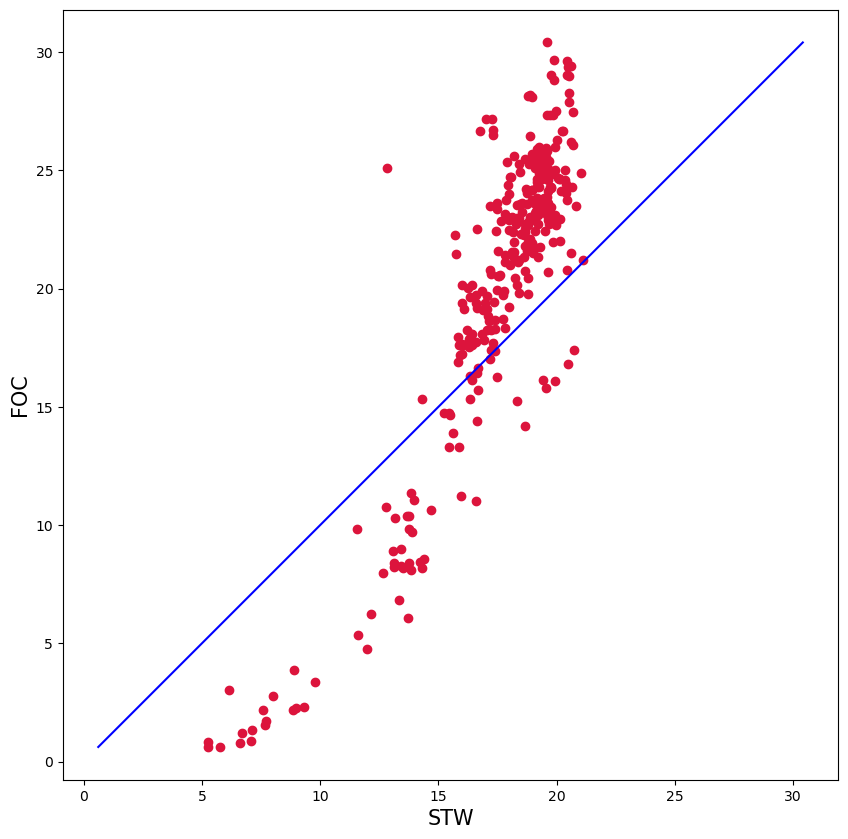

In [550]:
plt.figure(figsize=(10,10))
plt.scatter(dfprog['stw_act'], dfprog['foc_pred_d'], c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(dfprog['foc_pred_d']), max(dfprog['stw_act']))
p2 = min(min(dfprog['foc_pred_d']), min(dfprog['stw_act']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('STW', fontsize=15)
plt.ylabel('FOC', fontsize=15)
plt.axis('equal')
plt.show()

Hyperparameter Optimization

In [551]:
# from pprint import pprint
# pprint(model_rfr_ftr.get_params())

In [552]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 300, num = 10)]
# # Number of features to consider at every split
# max_features = [int(x) for x in np.linspace(1, 12, num = 11)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 200, num = 10)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

In [553]:
# rf_random = RandomizedSearchCV(estimator = model_rfr_hpov, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
# rf_random.fit(x_date, y_date)

In [554]:
# rf_random.best_params_

In [555]:
# def evaluate(model, test_features, test_labels):
#     from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error

#     predictions = model.predict(test_features)
#     rsquared = model.score(test_features,test_labels)
#     expVar = explained_variance_score(test_labels,predictions)
#     MAE = mean_absolute_error(test_labels,predictions)
#     MAD = median_absolute_error(test_labels,predictions)
#     RMSE = np.sqrt(mean_squared_error(test_labels,predictions))

#     print(f"Model Performance of {model}")
#     print(f"R^2: {rsquared:0.4f}")
#     print(f"explained Variance = {expVar:0.4f}")
#     print(f"MAE = {MAE:0.4f}")
#     print(f"RMSE = {RMSE:0.4f}")
#     print(f"MAD = {MAD:0.4f}\n")
    
#     return rsquared,expVar,MAE,RMSE,MAD

# base_model = model_rfr_hpov
# base_model.fit(x_date, y_date)
# rsquared_base,expVar_base,MAE_base,RMSE_base,MAD_base = evaluate(base_model, x_date, y_date)

# best_random = rf_random.best_estimator_
# rsquared_random,expVar_random,MAE_random,RMSE_random,MAD_random = evaluate(best_random, x_date, y_date)
# print('Improvement of Rsquared {:0.3f}%.'.format( 100 * (rsquared_random - rsquared_base) / rsquared_base))
# print('Improvement of explainedVariance {:0.3f}%.'.format( 100 * (expVar_random - expVar_base) / expVar_base))
# print('Improvement of MAE {:0.3f}%.'.format( 100 * (MAE_base - MAE_random) / MAE_base)) # MAE is other way around since best score is 0
# print('Improvement of RMSE {:0.3f}%.'.format( 100 * (RMSE_base - RMSE_random) / RMSE_base)) # RMSE is other way around since best score is 0
# print('Improvement of MAD {:0.3f}%.'.format( 100 * (MAD_base - MAD_random) / MAD_base)) # MAD is other way around since best score is 0